# Questions:

1) did we make the right 'mapping' between the notebook variables and the DIV1D papers?
2) can you help us find the necessary variables for calculating the PDE in the DIV1D dataset?
3) In the PDE for plasma density $n$ we also have $v_{||}$ that we are predicting, do we also input our predicted $\hat{v_{||}}$ in the PDE for $n$?
4) For atom density $n_a$ we have the $D_a$ term that is dependent on many variables that we are not predicting. Do we have all data for this?
5) Is e just eulers number?
6) For plasma energy, is $\kappa_{||}$ specified correctly?
7) Also for plasma energy, double derivation? (second derivative right?)
8) For plasma energy, is this $p$ again defined in the same way as for plasma momentum?
9) Our derivative wrt $x$ will be a vector. So in PDE of for example molecule density, is this just a point-wise multiplication or a dot product? Question has to do with the dimension that we work with in the PDE and losses.

# PINN (Physics Informed Neural Networks)

The idea is to calculate the PDEs for the real data and the prediction data and then calculate a loss that we can add to our MSE loss when training to include the phsycical properties into our loss.

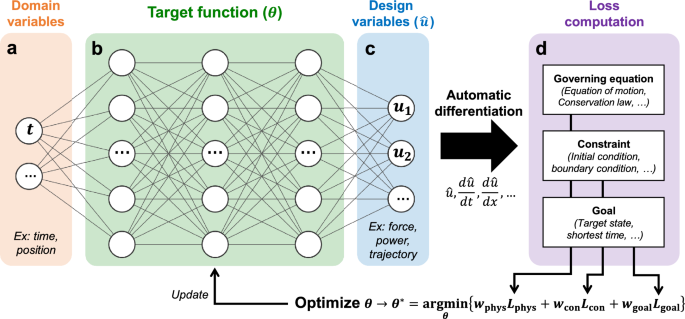

**Domain:** \
Let $x$ be the location on the divertor leg $\in [0, 500]$. \
Let $t$ be the timestep $\in [0, t_{max}]$.

**Input and output:**
We are predicting the following variables over x and t:
- $n$: plasma density (density of ions)
- $n_a$: neutral density (density of atoms)
- $v_{||}$: ion velocity parallel to the magnetic field (velocity of ions)
- $v_a$: the parallel neutral atom flow velocity (velocity of atoms)
- $T$: ion temperature (temperature of ions)
- $n_{m}$: molecule density (molecule density)

Note: names between brackets () correspond to names from the introduction jupyter notebook.

## PDEs

From the DIV1D papers we can use the following PDEs that correspond to the variables of interest:

---

**Plasma density $n$**:
$
\begin{equation}
    \frac{\partial n}{\partial t} = - B \frac{\partial}{\partial x} \left( \frac{\Gamma_n}{B} \right) + S_n = - B \frac{\partial}{\partial x} \left( \frac{n v_{||}}{B} \right) + S_n
\end{equation}
$ 
where 
- $n$ is the plasma density
- $v_{||}$ is the ion velocity parallel to the magnetic field
- $B$ is the magentic field in Tesla (T) and is given, it is an input parameter in the DIV1D model
- $S_n$ is a space and time dependent source term. This is a long and complex equation that depends on values from the AMJUEL database. We drop this term. 
\
\
Which would lead us to our loss:
$
\begin{equation}
    \mathcal{L}_{n} = \left( \frac{\partial n}{\partial t} - \frac{\partial \hat{n}}{\partial t} \right)^{2} 
    = B^{2} \left( \frac{\partial}{\partial x} \left( \frac{\hat{n} \hat{v_{||}}}{B} \right) - \frac{\partial}{\partial x} \left( \frac{n v_{||}}{B} \right) \right)^{2}
\end{equation}
$
with the following predictions from our model:
- $\hat{n}$ is the plasma density
- $\hat{v_{||}}$ is the ion velocity parallel to the magnetic field

---

**Plasma momentum**:

$
\begin{equation}
    \frac{\partial nmv_{||}}{\partial t} = - B \frac{\partial}{\partial x} \left( \frac{nmv^{2}_{||}}{B} \right) - \frac{\partial}{\partial x} 2neT + S_{mom}
\end{equation}
$
where
- $m$ is the mass of a deuteron
- $e$ is eulers number (?)
- $n$ is the plasma density
- $v_{||}$ is ion velocity parallel to the magnetic field
- $T$ is the temperature of the plasma (ion temperature)

Which would lead us to our loss:
$
\begin{equation}
    \mathcal{L}_{nmv_{||}} = \left( \frac{\partial nmv_{||}}{\partial t} - \frac{ \partial \hat{n} m \hat{v_{||}} }{\partial t} \right)^{2} 
    = \left( 
        \left[ - B \frac{\partial}{\partial x} \left( \frac{nmv^{2}_{||}}{B} \right) - \frac{\partial}{\partial x} 2neT \right]
        - \left[ - B \frac{\partial}{\partial x} \left( \frac{\hat{n}m\hat{v}^{2}_{||}}{B} \right) - \frac{\partial}{\partial x} 2\hat{n}e\hat{T} \right]
    \right)^{2}
\end{equation}
$
with the following predictions from our model:
- $\hat{n}$ is the plasma density
- $\hat{v_{||}}$ is ion velocity parallel to the magnetic field
- $\hat{T}$ is the temperature of the plasma (ion temperature)

---

**Plasma energy**

$
\begin{equation}
    \frac{\partial 3neT }{\partial t} = - B \frac{\partial}{\partial x} \left( \frac{q_{||}}{B} \right) + v_{||} \frac{\partial}{\partial x} 2neT + Q
\end{equation}
$
where
- $n$ is the plasma density
- $v_{||}$ is ion velocity parallel to the magnetic field
- $T$ is the temperature of the plasma (ion temperature)
- $Q$ is the source term in energy balance that is again a complex equation dependent on the AMJUEL database and hence we drop it.
- $q_{||}$ is the parallel heat flux density that has the following equation
$
\begin{equation}
    q_{||} = 5neTv_{||} - \kappa_{||} \frac{\partial}{\partial x}T
\end{equation}
$
- $\kappa_{||}$ is the parallel heat conductivity that has the following equation (referentie: DIV1D paper paragraaf tussen equation 5 en 6):
$
\begin{equation}
    \kappa_{||} = 2 \times 10^{3} T^{5/2}
\end{equation}
$
Note that $q_{||}$ depends entirely on predictions.
\
\
Which would lead us to our loss:
$
\begin{equation}
    \mathcal{L}_{3neT} = \left( \frac{\partial 3neT}{\partial t} - \frac{ \partial 3\hat{n} e \hat{T} }{\partial t} \right)^{2} 
    = \left( 
        \left[ - B \frac{\partial}{\partial x} \left( \frac{q_{||}}{B} \right) + v_{||} \frac{\partial}{\partial x} 2neT \right]
        - \left[ - B \frac{\partial}{\partial x} \left( \frac{\hat{q}_{||}}{B} \right) + \hat{v}_{||} \frac{\partial}{\partial x} 2\hat{n} e \hat{T}  \right]
    \right)^{2}
\end{equation}
$
where
$
\begin{equation}
    \hat{q_{||}} = 5 \hat{n} e \hat{T} \hat{v}_{||} - \hat{\kappa}_{||} \frac{\partial}{\partial x} \hat{T}
\end{equation}
$
and 
$
\begin{equation}
    \hat{\kappa_{||}} = 2 \times 10^{3} \hat{T}^{5/2}
\end{equation}
$
with the following predictions from our model:
- $\hat{n}$ is the plasma density
- $\hat{v_{||}}$ is ion velocity parallel to the magnetic field
- $\hat{T}$ is the temperature of the plasma (ion temperature)

---

**(neutral) Atom density $n_a$**:

$
\begin{equation}
    \frac{\partial n_a}{\partial t} = \frac{\partial}{\partial x} D_a \frac{\partial}{\partial x} n_a - \frac{\partial}{\partial x} (n_a v_a) + S_n 
\end{equation}
$
where
$
\begin{equation}
D_a = \frac{e \sqrt{T T_a}}{m (v_{cx} + v_{el}) sin^{2}\theta}
\end{equation}
$
and 
- $v_a$: the parallel neutral atom flow velocity
- $e$: eulers nummber (?)
- $m$: the mass of the deuteron atom ($m \approx m_a$)
- $T$: the temperature of the plasma (ion temperature)
- $T_a$: the temperature of the neutral atoms
- $v_{cx}$: charge exchange collision frequency
- $v_{el}$: elastic plasma-atom collision frequency
- $sin \space \theta$: ratio of poloidal to total grid step size 
- $S_n$ is a source term that we will drop \
\
Then our loss can be defined as:
$
\begin{equation}
    \mathcal{L}_{n_a} = \left( \frac{\partial n_a}{\partial t} - \frac{\partial \hat{n_a}}{\partial t} \right)^{2} 
    = \left( 
        \left[ \frac{\partial}{\partial x} D_a \frac{\partial}{\partial x} n_a - \frac{\partial}{\partial x} (n_a v_a) \right] -
        \left[ \frac{\partial}{\partial x} \hat{D}_a \frac{\partial}{\partial x} \hat{n_a} - \frac{\partial}{\partial x} \left( \hat{n_a} \hat{v_a} \right) \right]
     \right)^{2}
\end{equation}
$
where
$
\begin{equation}
D_a = \frac{e \sqrt{\hat{T} T_a}}{m (v_{cx} + v_{el}) sin^{2}\theta}
\end{equation}
$
with predictions:
- $\hat{T}$ is the temperature of the plasma (ion temperature)
- $\hat{v_a}$ is the parallel neutral atom flow velocity

---

**neutral atom momentum**

$
\begin{equation}
    \frac{\partial n_a m_a v_a}{\partial t} = - \frac{\partial}{\partial x} (n_a m_a v^{2}_a) - \frac{\partial}{\partial x} \left( e n_a T_a \right) + S_{\text{mom}, a}
\end{equation}
$
where
- $n_a$: neutral atom density
- $m_a$: is the mass of the neutral atom ($m_a$ $\approx$ $m$)
- $v_a$: is the arallel neutral atom flow velocity 
- $T_a$: the neutral temperature
- $S_{\text{mom}, a}$: is a source term that we will drop
\
\
Then our loss can be defined as:
$
\begin{equation}
    \mathcal{L}_{n_a m_a v_a} = \left( \frac{\partial n_a m_a v_a}{\partial t} - \frac{\partial \hat{n_a} m_a \hat{v_a}}{\partial t} \right)^{2} 
    = \left( 
        \left[ - \frac{\partial}{\partial x} (n_a m_a v^{2}_a) - \frac{\partial}{\partial x} \left( e n_a T_a \right) \right] -
        \left[ - \frac{\partial}{\partial x} (\hat{n}_a m_a \hat{v}^{2}_a) - \frac{\partial}{\partial x} \left( e \hat{n}_a T_a \right) \right]
     \right)^{2}
\end{equation}
$
with predictions:
- $\hat{n}_a$: neutral atom density
- $\hat{v}_a$: the arallel neutral atom flow velocity 

---

**molecule density**

$
\begin{equation}
    \frac{\partial n_m}{\partial t} = - \frac{\partial}{\partial x} D \frac{\partial}{\partial x} n_m + S_m
\end{equation}
$
where
$
\begin{equation}
    D = \frac{ eT }{ m v_{cx} \text{sin}^{2}\theta }
\end{equation}
$
and
- $n_m$: is the molecule density
- $S_m$: is a source term that we drop
- $e$: eulers constant (?)
- $T$: the temperature of the plasma (ion temperature)
- $m$: the mass of the deuteron atom ($m \approx m_a$)
- $v_{cx}$: charge exchange collision frequency
- $\text{sin} \space \theta$: ratio of poloidal to total grid step size 
\
\
Then our loss can be defined as:
$
\begin{equation}
    \mathcal{L}_{n_m} = \left( \frac{\partial n_m}{\partial t} - \frac{\partial \hat{n_m}}{\partial t} \right)^{2} 
    = \left( 
        \left[ - \frac{\partial}{\partial x} D \frac{\partial}{\partial x} n_m \right] -
        \left[ - \frac{\partial}{\partial x} \hat{D} \frac{\partial}{\partial x} \hat{n}_m \right]
     \right)^{2}
\end{equation}
$
where
$
\begin{equation}
    \hat{D} = \frac{ e \hat{T} }{ m v_{cx} \text{sin}^{2}\theta }
\end{equation}
$
with predictions:
- $\hat{n}_m$: is the molecule density
- $\hat{T}$: the temperature of the plasma (ion temperature)

---

## Variable mapping: from PDEs to the dataset

In this section we detail how to extract the extra variables from the dataset. Where extra variables are the ones we are not predicting, but do need to determine the PDE.

From file div1d.mat

| Variable | File | Input/Output |  Physics/Grid | Key | Notes |
| --- | --- | --- | --- | --- | --- |
| $T_a$ | div1d_output.mat | input | physics | neutral energy | |
| $m$ | div1d_output.mat | input | physics | mass |  |
| $B$ | div1d_output.mat | input | grid | b_field | |
| $\text{sin} \space \theta$ | div1d_output.mat | input | grid | sintheta_cc (cb) | cb is for the boundary |
| S_i | div1d_output.mat | output | -| Source_n | |
| $v_{cx}$ | na | na | na | na | Not available |
| $v_{el}$ | na | na | na | na | Not available |

In [6]:
import scipy.io
mat_file = "div1d_output.mat"

# Read the mat file
mat = scipy.io.loadmat(mat_file)
print("The mat file has the following keys:", mat.keys())

print(mat["input"][0]["grid"][0].dtype)

print(mat["input"][0]["physics"][0].dtype)

print(mat["output"].dtype)

The mat file has the following keys: dict_keys(['__header__', '__version__', '__globals__', 'output', 'input'])
[('i_omp', 'O'), ('i_xpoint', 'O'), ('i_baffle', 'O'), ('mid_point', 'O'), ('x_omp', 'O'), ('x', 'O'), ('xcb', 'O'), ('b_field', 'O'), ('b_field_cb', 'O'), ('b_trans', 'O'), ('b_trans_cb', 'O'), ('area_extern', 'O'), ('r_cc', 'O'), ('r_cb', 'O'), ('z_cc', 'O'), ('z_cb', 'O'), ('nr_cc', 'O'), ('nz_cc', 'O'), ('sintheta_cc', 'O'), ('sintheta_cb', 'O'), ('sol_width_pol', 'O'), ('sol_width_pol_cb', 'O'), ('volumes', 'O'), ('gas_puff_profile', 'O'), ('e_core_source_profile_q', 'O'), ('e_core_source_profile_n', 'O'), ('prf_imp_con', 'O')]
[('gamma', 'O'), ('l', 'O'), ('sintheta', 'O'), ('mass', 'O'), ('gamma_x', 'O'), ('q_parx', 'O'), ('q_core', 'O'), ('gamma_core', 'O'), ('flux_expansion', 'O'), ('trans_expansion', 'O'), ('initial_n', 'O'), ('initial_v', 'O'), ('initial_vn', 'O'), ('initial_t', 'O'), ('initial_a', 'O'), ('initial_m', 'O'), ('initial_nb', 'O'), ('initial_mb', 'O'),